# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-08 10:52:25.812466: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-08 10:52:25.817967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 10:52:25.817983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [3]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [4]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()


2022-06-08 10:52:32.113924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 10:52:32.113967: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 10:52:32.113995: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-08 10:52:32.114521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [5]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 1  

def units(j): return (j+8)
units_range = 1

In [15]:
#quantized settings
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4

    return (i*2)

array =[2,4,6,8,10,12,14]
def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 7

In [17]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path0(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest8.h5"
def qpredicts_path0(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest8.npy"

def qmodels_path0b(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest8,refbm.h5"
def qpredicts_path0b(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest8,refbm.npy"

def qmodels_path9(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest9.h5"
def qpredicts_path9(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest9.npy"

def qmodels_path9b(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest9,refbm.h5"
def qpredicts_path9b(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest9,refbm.npy"

def qmodels_path1(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest10.h5"
def qpredicts_path1(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest10.npy"

def qmodels_path1b(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest10,refbm.h5"
def qpredicts_path1b(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{array[i]},{integer}>,rest10,refbm.npy"

def qmodels_path2(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest12.h5"
def qpredicts_path2(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest12.npy"




def qmodels_path3(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest16.h5"
def qpredicts_path3(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest16.npy"

#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"
def qtrained_predicts_path(j, i):  return f"tests/qpredicts_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.npy"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

# 3. Compare the results

In [8]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')

## Predictions

tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>,rest9,refbm.npy already exists


In [18]:
for i in range(len(array)):
    print(f"mse of {qpredicts_path9b(i)}={mse(y_test, np.load(qpredicts_path9b(i)))}")
    print(qkeras.utils.load_qmodel(qmodels_path9b(i)).layers[0].recurrent_quantizer)


mse of tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<0,0>,rest9,refbm.npy=1.1021706995961722e-05
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 4, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
mse of tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>,rest9,refbm.npy=1.0606648174871225e-05
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 6, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
mse of tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<4,0>,rest9,refbm.npy=1.024238645186415e-05
{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 4, 'integer': 0, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
mse of tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_m

In [9]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)
ref_path = 'tests/ref_predicts.npy'
exist(ref_path, boosted_model)

for i in range(bits_range):

    """qmodel0 = qkeras.utils.load_qmodel(qmodels_path0(i))        
    exist(qpredicts_path0(i), qmodel0)"""

    qmodel0b = qkeras.utils.load_qmodel(qmodels_path0b(i))        
    exist(qpredicts_path0b(i), qmodel0b)

    """qmodel9 = qkeras.utils.load_qmodel(qmodels_path9(i))        
    exist(qpredicts_path9(i), qmodel9)"""
    
    qmodel9b = qkeras.utils.load_qmodel(qmodels_path9b(i))        
    exist(qpredicts_path9b(i), qmodel9b)

    """qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
    exist(qpredicts_path1(i), qmodel1)"""
    qmodel1b = qkeras.utils.load_qmodel(qmodels_path1b(i))        
    exist(qpredicts_path1b(i), qmodel1b)
    
    """qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
    exist(qpredicts_path2(i), qmodel2)"""

    """qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
    exist(qpredicts_path3(i), qmodel3)"""
    




tests/predicts/optimized_model.npy already exists
tests/ref_predicts.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>,rest8,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>,rest9,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<2,0>,rest10,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<4,0>,rest8,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<4,0>,rest9,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<4,0>,rest10,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>,rest8,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>,rest9,refbm.npy already exists
tests/qpredicts/qmodels_patiencES=12_p

## Plotting

In [12]:
loss0 = []
loss9 = []
loss1 = [] 
loss2 = []
loss3 = []


bit_nbr = []
for i in range(bits_range):
    bit_nbr.append(bit_lenghts(i))
    y_qkeras0 = np.load(qpredicts_path0(i))
    y_qkeras9 = np.load(qpredicts_path9(i))
    y_qkeras1 = np.load(qpredicts_path1(i))
    y_qkeras2 = np.load(qpredicts_path2(i))
    y_qkeras3 = np.load(qpredicts_path3(i))

    
    loss0.append(mse(y_test,y_qkeras0))        
    loss9.append(mse(y_test,y_qkeras9))        
    loss1.append(mse(y_test,y_qkeras1))        
    loss2.append(mse(y_test,y_qkeras2))
    loss3.append(mse(y_test,y_qkeras3))


plt.figure()
plt.plot(loss0)
plt.plot(loss9)
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.axhline(mse(y_test, np.load(predicts_path(0))), linestyle="--", color = 'red')

plt.legend(['rest set to <8,0>','rest set to <9,0>','rest set to <10,0>','rest set to <12,0>','rest set to <16,0>','ref'])
plt.xticks(np.arange(len(bit_nbr)), [f"<{Bit},{integer}>" for Bit in bit_nbr])
plt.xlabel('bits settings')
plt.yscale('log')
plt.ylabel('MSE')
plt.title(f'MSE qkeras, comparison with differente bitwidth for the rkernel, integer={integer}')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'tests/qpredicts/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<4,0>,rest8.npy'

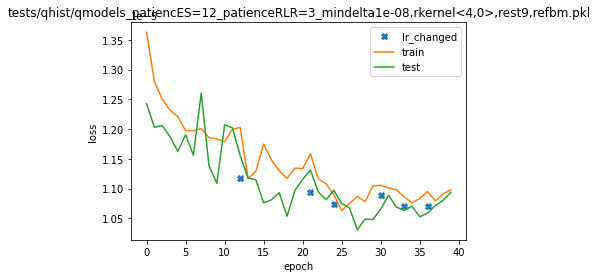

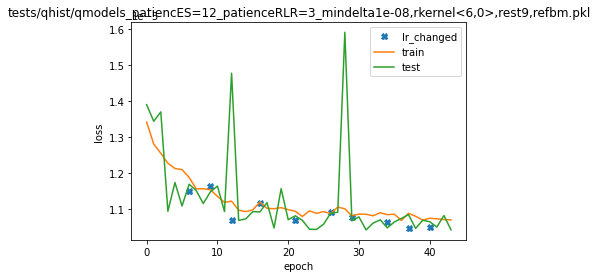

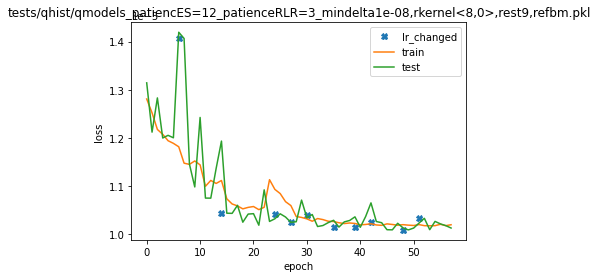

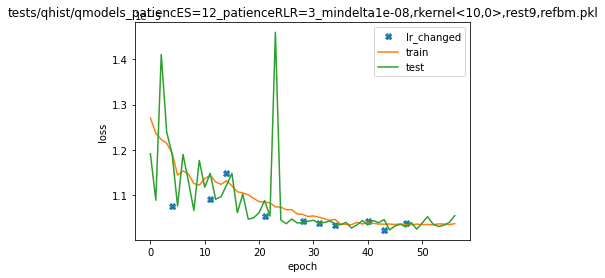

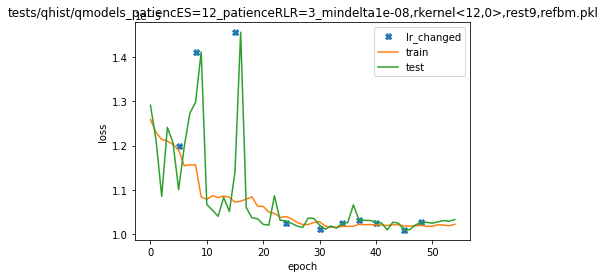

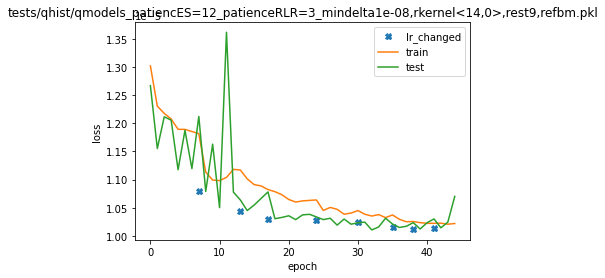

In [13]:
def qhist_path(i): return f"tests/qhist/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest9,refbm.pkl"
for i in range (bits_range):
    file_to_read = open(qhist_path(i), "rb")

    hist = pickle.load(file_to_read)
    lr_change = []
    for k in range (len(hist['lr'])-1):

        if (hist['lr'][k]==hist['lr'][k+1]):
            lr_change.append(None)
        else:
            lr_change.append(hist['val_loss'][k+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(qhist_path(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()

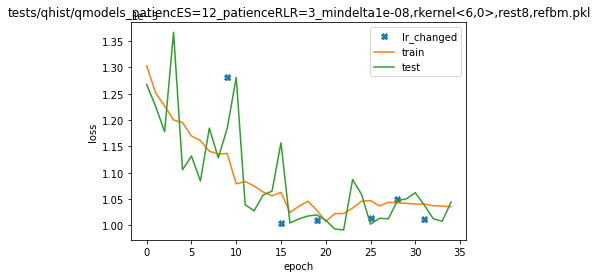

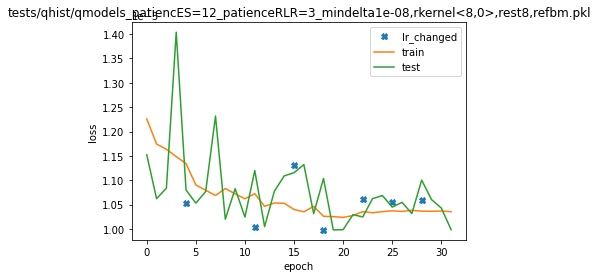

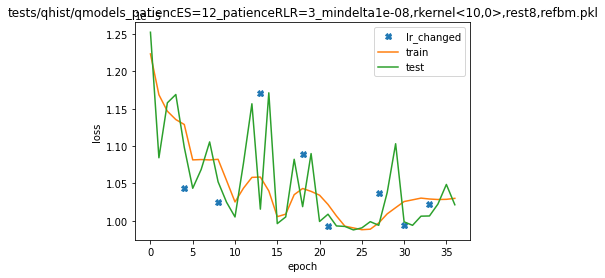

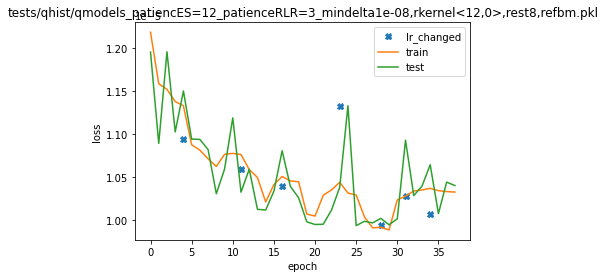

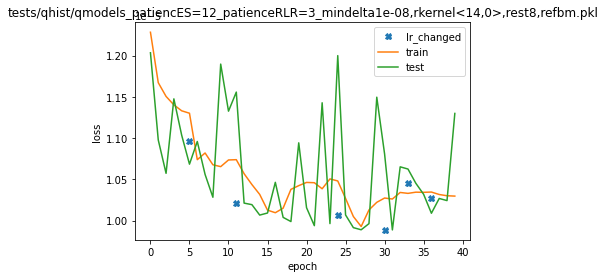

In [20]:
def qhist_path(i): return f"tests/qhist/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest8,refbm.pkl"
for i in range (bits_range):
    file_to_read = open(qhist_path(i), "rb")

    hist = pickle.load(file_to_read)
    lr_change = []
    for k in range (len(hist['lr'])-1):

        if (hist['lr'][k]==hist['lr'][k+1]):
            lr_change.append(None)
        else:
            lr_change.append(hist['val_loss'][k+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(qhist_path(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()

1.096602e-05
1.1021707e-05
1.1839618e-05
1.1967798e-05
1.0606648e-05
1.0062904e-05
9.82008e-06
1.0242386e-05
9.830042e-06
9.842277e-06
1.0340637e-05
9.73364e-06
9.789902e-06
1.0053961e-05
9.740956e-06
9.83866e-06
1.0206626e-05
9.774829e-06
9.835713e-06
1.0018581e-05
9.833416e-06


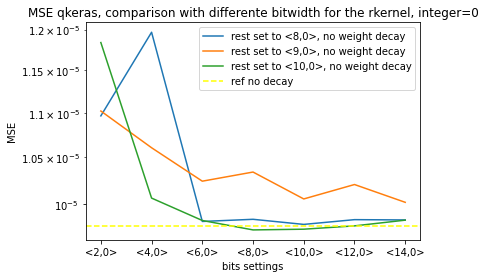

In [19]:
loss0 = []
loss0b = []
loss9 = []
loss9b = []
loss1 = [] 
loss1b = [] 
loss2 = []
loss3 = []

bit_nbr = []
for i in range(bits_range):
    bit_nbr = array
    #y_qkeras0 = np.load(qpredicts_path0(i))
    y_qkeras0b = np.load(qpredicts_path0b(i))
    #y_qkeras9 = np.load(qpredicts_path9(i))    
    y_qkeras9b = np.load(qpredicts_path9b(i))
    #y_qkeras1 = np.load(qpredicts_path1(i))
    y_qkeras1b = np.load(qpredicts_path1b(i))


    
    #loss0.append(mse(y_test,y_qkeras0))        
    loss0b.append(mse(y_test,y_qkeras0b))
    print(mse(y_test,y_qkeras0b))  
    #loss9.append(mse(y_test,y_qkeras9))        
    loss9b.append(mse(y_test,y_qkeras9b))        
    print(mse(y_test,y_qkeras9b))  
 
    #loss1.append(mse(y_test,y_qkeras1))        
    loss1b.append(mse(y_test,y_qkeras1b))        
    print(mse(y_test,y_qkeras1b))  



plt.figure()
#plt.plot(loss0)
plt.plot(loss0b)
#plt.plot(loss9)
plt.plot(loss9b)
#plt.plot(loss1)
plt.plot(loss1b)
#plt.axhline(mse(y_test, np.load(predicts_path(0))), linestyle="--", color = 'red')
plt.axhline(mse(y_test, np.load(ref_path)), linestyle="--", color = 'yellow')
plt.legend(['rest set to <8,0>, no weight decay','rest set to <9,0>, no weight decay','rest set to <10,0>, no weight decay', 'ref no decay']) #
plt.xticks(np.arange(len(bit_nbr)), [f"<{Bit},{integer}>" for Bit in bit_nbr])
plt.xlabel('bits settings')
plt.yscale('log')
plt.ylabel('MSE')
plt.title(f'MSE qkeras, comparison with differente bitwidth for the rkernel, integer={integer}')
plt.show()

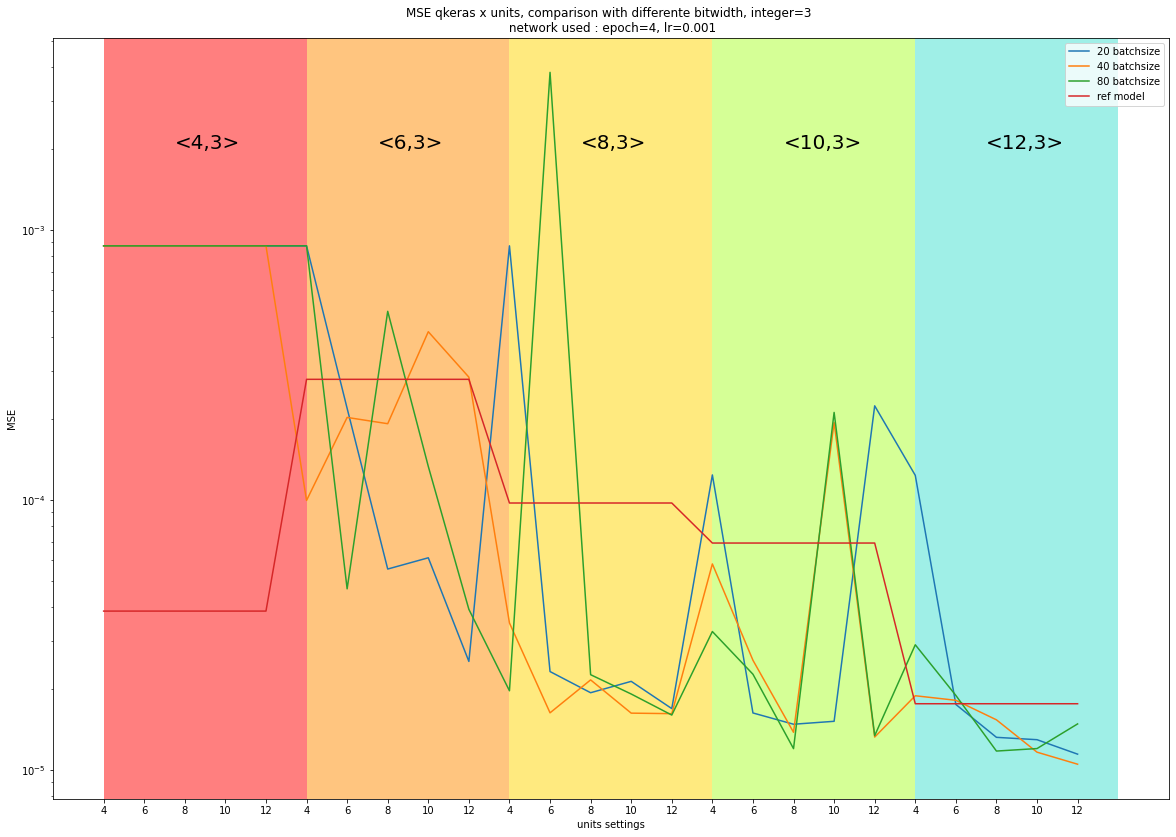

In [10]:
    plt.figure(figsize=(20,14))
    plt.plot(loss1)
    plt.plot(loss2)
    plt.plot(loss3)
    plt.plot(loss4)
    plt.legend(['20 batchsize','40 batchsize','80 batchsize','ref model'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    
    plt.axvspan(0, 5, facecolor='red', alpha=0.5)
    plt.text(1.75, 0.002, "<4,3>", fontsize = 20 )
    plt.text(6.75, 0.002, "<6,3>", fontsize = 20 )
    plt.text(11.75, 0.002, "<8,3>", fontsize = 20 )
    plt.text(16.75, 0.002, "<10,3>", fontsize = 20 )
    plt.text(21.75, 0.002, "<12,3>", fontsize = 20 )
   
    
    plt.axvspan(5, 10, facecolor='darkorange', alpha=0.5)
    plt.axvspan(10, 15, facecolor='gold', alpha=0.5)
    plt.axvspan(15, 20, facecolor='greenyellow', alpha=0.5)    
    plt.axvspan(20, 25, facecolor='turquoise', alpha=0.5)
 
  
    plt.xlabel('units settings')
    plt.yscale('log')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras x units, comparison with differente bitwidth, integer={integer} \n network used : epoch={nbr_conv_epoch}, lr={lr}')
    plt.show()

31250/31250 [==============================] - 43s 1ms/step


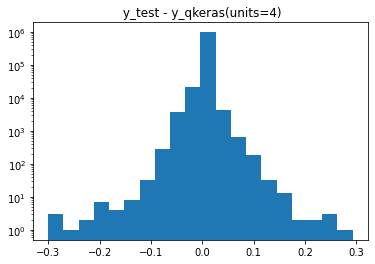

31250/31250 [==============================] - 44s 1ms/step


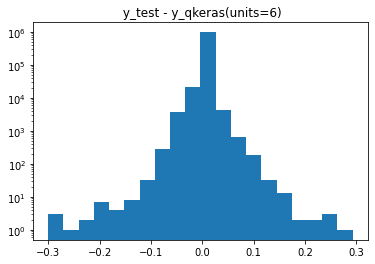

31250/31250 [==============================] - 42s 1ms/step


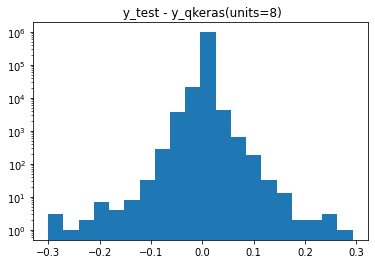

31250/31250 [==============================] - 42s 1ms/step


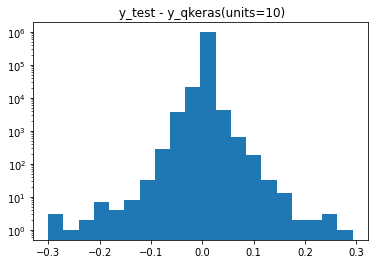

31250/31250 [==============================] - 43s 1ms/step


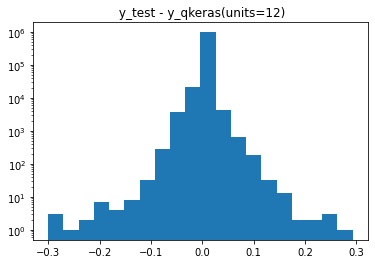

31250/31250 [==============================] - 44s 1ms/step


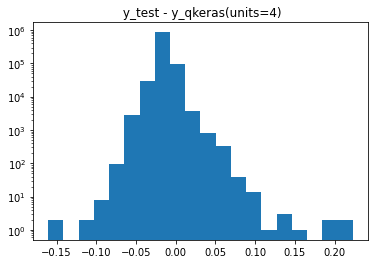

31250/31250 [==============================] - 43s 1ms/step


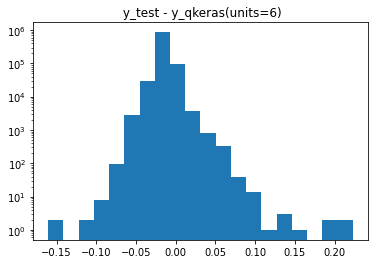

31250/31250 [==============================] - 45s 1ms/step


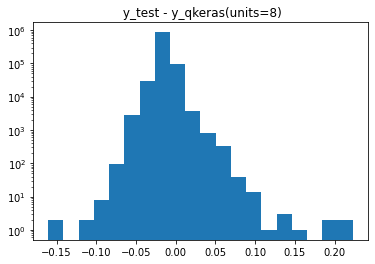

31250/31250 [==============================] - 44s 1ms/step


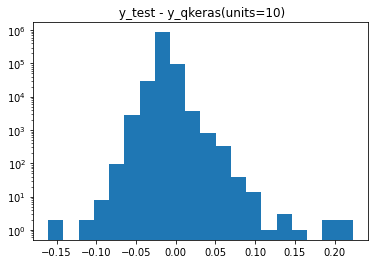

31250/31250 [==============================] - 43s 1ms/step


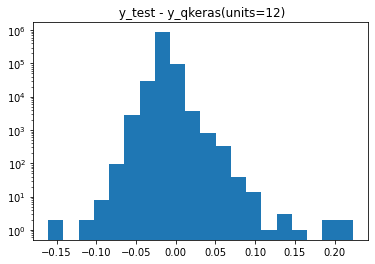

31250/31250 [==============================] - 47s 1ms/step


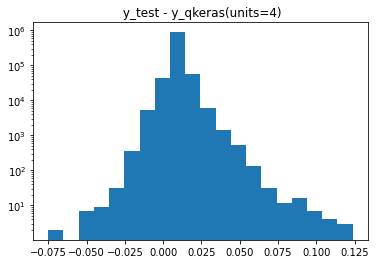

31250/31250 [==============================] - 48s 2ms/step


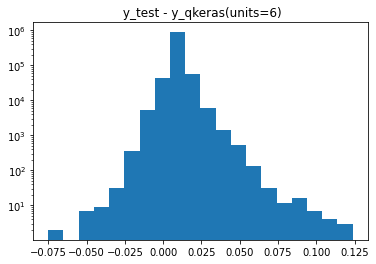

31250/31250 [==============================] - 48s 2ms/step


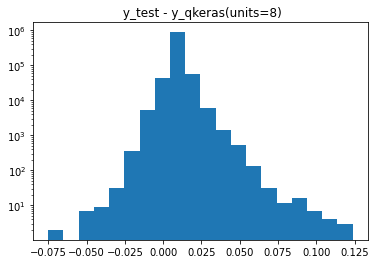

31250/31250 [==============================] - 45s 1ms/step


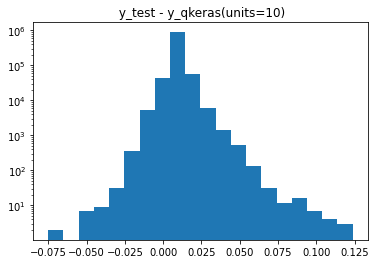

31250/31250 [==============================] - 49s 2ms/step


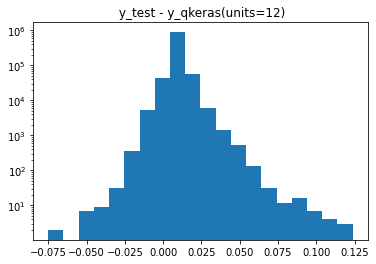

31250/31250 [==============================] - 43s 1ms/step


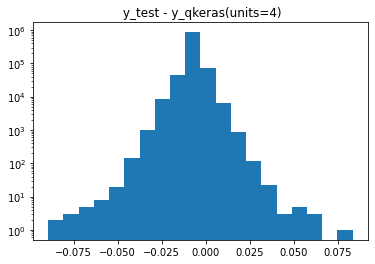

31250/31250 [==============================] - 42s 1ms/step


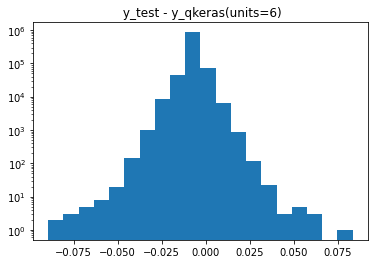

31250/31250 [==============================] - 42s 1ms/step


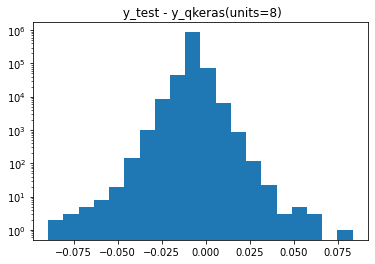

31250/31250 [==============================] - 46s 1ms/step


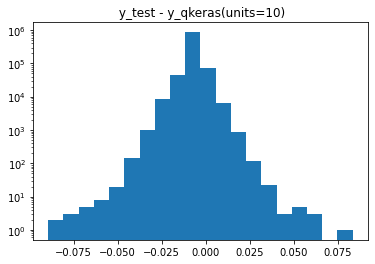

31250/31250 [==============================] - 44s 1ms/step


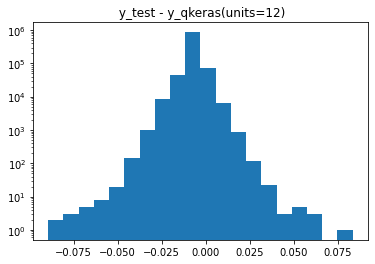

31250/31250 [==============================] - 44s 1ms/step


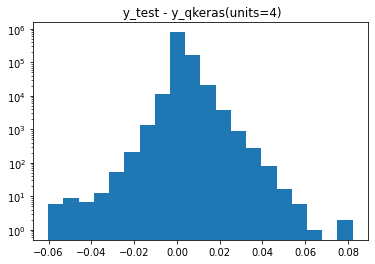

31250/31250 [==============================] - 45s 1ms/step


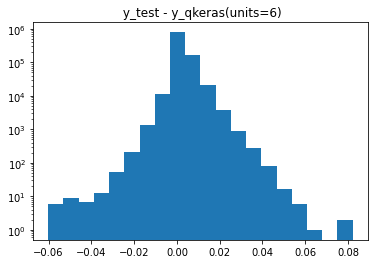

31250/31250 [==============================] - 46s 1ms/step


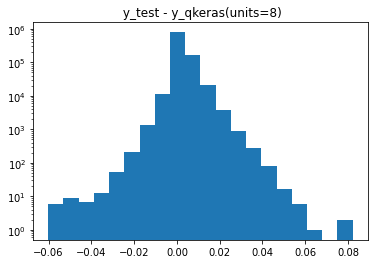

31250/31250 [==============================] - 49s 2ms/step


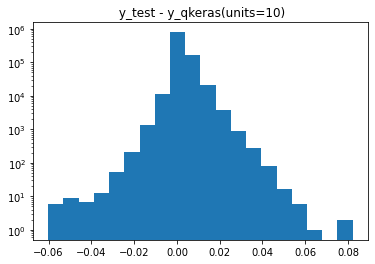

31250/31250 [==============================] - 48s 2ms/step


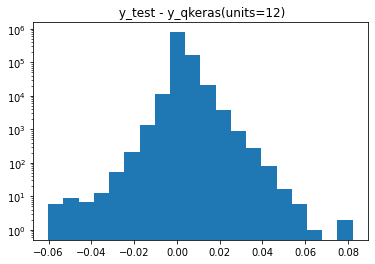

In [ ]:
bit_nbr = []
loss3 = []
loss4 = []
unit_nbr = []

for i in range(bits_range):
        qmodel4 = qkeras.utils.load_qmodel(f'qmodels_epoch=4/qmodels_units,<{bit_lenghts(i)},3>.h5')        
        y_qkeras4 = qmodel4.predict(x_test)
        for j in range(units_range):
                qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(j,i))        
                y_qkeras3 = qmodel3.predict(x_test)                        

                loss3.append(mse(y_test,y_qkeras3))
                loss4.append(mse(y_test,y_qkeras4))

                plt.figure()
                plt.hist(y_test-y_qkeras4, bins=20)
                plt.yscale('log')
                plt.title(f' y_test - y_qkeras(units={units(j)})')
                plt.show()